In [ ]:
!nvidia-smi

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer

data = pd.read_csv('/kaggle/input/medicaltranscriptions/mtsamples.csv')

data = data.fillna("")

data['text'] = data['description'] + " " + data['transcription'] + " " + data['keywords']

specialties = data['medical_specialty'].unique()
label_map = {specialty: idx for idx, specialty in enumerate(specialties)}
data['label'] = data['medical_specialty'].map(label_map)

train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['text'], data['label'], test_size=0.2, random_state=42)

tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

In [ ]:
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=512)

import torch

train_labels = torch.tensor(train_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())

train_encodings = {key: torch.tensor(val) for key, val in train_encodings.items()}
val_encodings = {key: torch.tensor(val) for key, val in val_encodings.items()}

In [ ]:
from torch.utils.data import Dataset, DataLoader

class MedicalTranscriptionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = MedicalTranscriptionDataset(train_encodings, train_labels)
val_dataset = MedicalTranscriptionDataset(val_encodings, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [ ]:
from transformers import BertForSequenceClassification, AdamW, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(specialties))
model.to('cuda:0')

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

trainer.train()

In [ ]:
eval_results = trainer.evaluate()
print(eval_results)
print(f"Validation accuracy: {eval_results['eval_accuracy']:.4f}")

In [ ]:
def predict(texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=512, return_tensors='pt')
    outputs = model(**encodings)
    predictions = torch.argmax(outputs.logits, dim=1)
    return [specialties[pred] for pred in predictions]

new_texts = ["A 23-year-old female presents with complaint of allergies.", "Consult for laparoscopic gastric bypass."]
predictions = predict(new_texts)
print(predictions)

In [34]:
data[['medical_specialty', 'transcription']]

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
...,...,...
4994,Allergy / Immunology,"HISTORY:, I had the pleasure of meeting and e..."
4995,Allergy / Immunology,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH..."
4996,Allergy / Immunology,"SUBJECTIVE: , This is a 42-year-old white fema..."
4997,Allergy / Immunology,"CHIEF COMPLAINT: , This 5-year-old male presen..."


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'eval_loss': 3.7826240062713623, 'eval_accuracy': 0.002, 'eval_precision': 4.008016032064128e-06, 'eval_recall': 0.002, 'eval_f1': 8e-06, 'eval_runtime': 5.6357, 'eval_samples_per_second': 177.442, 'eval_steps_per_second': 11.179}
Training Set Label Distribution: Counter({38: 882, 5: 413, 3: 298, 27: 284, 33: 218, 15: 207, 14: 184, 22: 178, 35: 133, 24: 128, 39: 126, 10: 86, 11: 78, 23: 75, 16: 72, 26: 66, 21: 65, 12: 60, 29: 56, 28: 50, 32: 42, 25: 41, 31: 38, 8: 23, 6: 22, 7: 22, 20: 18, 30: 17, 36: 16, 13: 15, 2: 14, 18: 13, 4: 11, 34: 8, 9: 8, 37: 7, 1: 7, 19: 7, 0: 6, 17: 5})
Validation Set Label Distribution: Counter({38: 221, 5: 103, 3: 74, 27: 71, 33: 55, 15: 52, 14: 46, 22: 45, 35: 33, 39: 32, 24: 32, 10: 22, 11: 20, 23: 19, 16: 18, 26: 17, 21: 16, 12: 15, 29: 14, 28: 12, 32: 11, 25: 10, 31: 9, 8: 6, 7: 5, 20: 5, 6: 5, 30: 4, 13: 4, 36: 4, 2: 4, 18: 3, 4: 3, 37: 2, 9: 2, 34: 2, 0: 1, 17: 1, 1: 1, 19: 1})
Confusion Matrix:
[[  0   0   0 ...   1   0   0]
 [  0   0   0 ...   1  

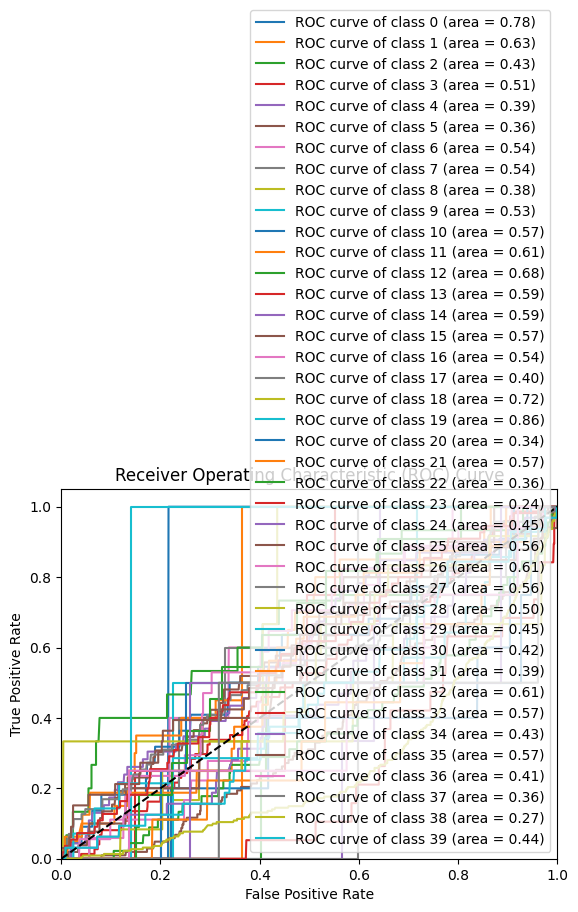

NameError: name 'precision_recall_curve' is not defined

In [35]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

data = pd.read_csv('/kaggle/input/medicaltranscriptions/mtsamples.csv') 

texts = data['transcription'].astype(str).tolist()  
labels = data['medical_specialty'].astype('category').cat.codes.tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels
)

tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(set(labels)))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train

metrics = trainer.evaluate()
print(metrics)

from collections import Counter

print("Training Set Label Distribution:", Counter(train_labels))
print("Validation Set Label Distribution:", Counter(val_labels))

val_preds = trainer.predict(val_dataset)
preds = val_preds.predictions.argmax(-1)
probs = torch.nn.functional.softmax(torch.tensor(val_preds.predictions), dim=-1).numpy()

cm = confusion_matrix(val_labels, preds)
report = classification_report(val_labels, preds)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

from sklearn.preprocessing import label_binarize

if len(set(val_labels)) > 1:
    # Binarize the labels for AUC computation
    val_labels_binarized = label_binarize(val_labels, classes=range(len(set(labels))))

    # Compute AUC and PR curves
    roc_auc = roc_auc_score(val_labels_binarized, probs, multi_class='ovr')

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(set(labels))):
        fpr[i], tpr[i], _ = roc_curve(val_labels_binarized[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(len(set(labels))):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Precision-Recall curve
    precision = dict()
    recall = dict()
    pr_auc = dict()
    for i in range(len(set(labels))):
        precision[i], recall[i], _ = precision_recall_curve(val_labels_binarized[:, i], probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure()
    for i in range(len(set(labels))):
        plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {i} (area = {pr_auc[i]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("Not enough classes in validation set to compute ROC AUC and PR curves.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,2.404100,2.472634,0.355000,0.158293,0.355000,0.203321


{'eval_loss': 2.4726343154907227, 'eval_accuracy': 0.355, 'eval_precision': 0.15829338740328194, 'eval_recall': 0.355, 'eval_f1': 0.20332071213866418, 'eval_runtime': 5.6812, 'eval_samples_per_second': 176.019, 'eval_steps_per_second': 11.089, 'epoch': 1.0}
Training Set Label Distribution: Counter({38: 882, 5: 413, 3: 298, 27: 284, 33: 218, 15: 207, 14: 184, 22: 178, 35: 133, 24: 128, 39: 126, 10: 86, 11: 78, 23: 75, 16: 72, 26: 66, 21: 65, 12: 60, 29: 56, 28: 50, 32: 42, 25: 41, 31: 38, 8: 23, 6: 22, 7: 22, 20: 18, 30: 17, 36: 16, 13: 15, 2: 14, 18: 13, 4: 11, 34: 8, 9: 8, 37: 7, 1: 7, 19: 7, 0: 6, 17: 5})
Validation Set Label Distribution: Counter({38: 221, 5: 103, 3: 74, 27: 71, 33: 55, 15: 52, 14: 46, 22: 45, 35: 33, 24: 32, 39: 32, 10: 22, 11: 20, 23: 19, 16: 18, 26: 17, 21: 16, 12: 15, 29: 14, 28: 12, 32: 11, 25: 10, 31: 9, 8: 6, 6: 5, 20: 5, 7: 5, 2: 4, 13: 4, 30: 4, 36: 4, 4: 3, 18: 3, 34: 2, 37: 2, 9: 2, 0: 1, 1: 1, 19: 1, 17: 1})
Confusion Matrix:
[[  0   0   0 ...   0   0   

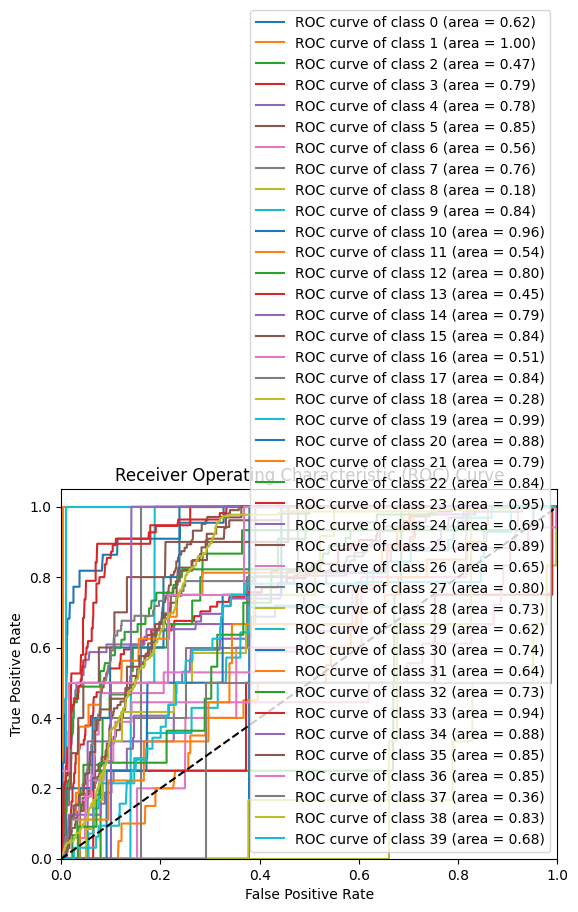

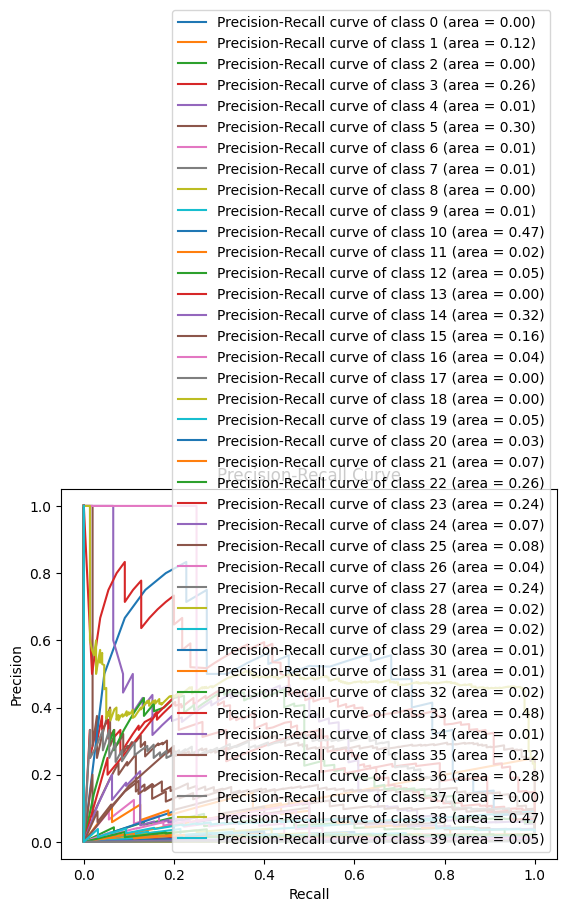

In [36]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.preprocessing import label_binarize

data = pd.read_csv('/kaggle/input/medicaltranscriptions/mtsamples.csv')

texts = data['transcription'].astype(str).tolist()
labels = data['medical_specialty'].astype('category').cat.codes.tolist()

train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels
)

tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

def tokenize_function(texts):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
    }

model = BertForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=len(set(labels)))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

metrics = trainer.evaluate()
print(metrics)

print("Training Set Label Distribution:", Counter(train_labels))
print("Validation Set Label Distribution:", Counter(val_labels))

val_preds = trainer.predict(val_dataset)
preds = val_preds.predictions.argmax(-1)
probs = torch.nn.functional.softmax(torch.tensor(val_preds.predictions), dim=-1).numpy()

cm = confusion_matrix(val_labels, preds)
report = classification_report(val_labels, preds)

print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

if len(set(val_labels)) > 1:
    val_labels_binarized = label_binarize(val_labels, classes=range(len(set(labels))))

    roc_auc = {}
    fpr = {}
    tpr = {}
    for i in range(len(set(labels))):
        fpr[i], tpr[i], _ = roc_curve(val_labels_binarized[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    for i in range(len(set(labels))):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    precision = {}
    recall = {}
    pr_auc = {}
    for i in range(len(set(labels))):
        precision[i], recall[i], _ = precision_recall_curve(val_labels_binarized[:, i], probs[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    plt.figure()
    for i in range(len(set(labels))):
        plt.plot(recall[i], precision[i], label=f'Precision-Recall curve of class {i} (area = {pr_auc[i]:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("Not enough classes in validation set to compute ROC AUC and PR curves.")